# 概要
+ IRDB（https://irdb.nii.ac.jp/）から、JPCOAR加盟機関のデータをスクレイピングして、若干の分析を行う。
+ JPCOAR加盟機関は、https://jpcoar.repo.nii.ac.jp/page/40 から抽出し、「図書館」などの文字列を削除し、機関名を抽出

// https://irdb.nii.ac.jp/search?kikanid=&facet%5B0%5D=orgnm%3A2287　が文部科学省　科学技術・学術政策研究所　の番号らしい


In [1]:
import pickle

inst_array = []
# insts = 　　[　　'東京大学',　　'東北大学',　　'東京工業大学'　　]
# 機関名を羅列したテキストファイルを読み込んで配列に代入
with open('kikanmei.txt', 'r',encoding="utf-8_sig") as f:
    insts = f.read().split("\n")

for inst in insts:
    inst_array.append(inst)

# 配列（list）をpickleに保存
with open("inst_array.pkl","wb") as f:
    pickle.dump(inst_array, f)

In [ ]:
import pickle

# 保存済みの機関名の配列を読み込み
with open('inst_array.pkl', 'rb') as f:
    institutions = pickle.load(f)
    
## 必要なライブラリのインポート ————–
# スクレイピング
from bs4 import BeautifulSoup
import time
import requests
import traceback
import logging
logger = logging.getLogger()

def main():
  type_list = {}
  #type_list = scrap('東北大学')
  for kikan in institutions:
    time.sleep(1)
    # 1秒スリープ
    type_list[kikan] = scrap(kikan)
    # type_list = scrap(kikan)
  # print(type_list)
  return type_list

def scrap(kikan):
  URL = 'https://irdb.nii.ac.jp/search?kikanid=' + kikan
  # スクレイピング —————————
  try:
    # URLを開く
    response = requests.get(URL)
    # HTMLを取得
    soup = BeautifulSoup(response.content, 'html.parser')
    logger.info('webサイトと接続できました')
  except:
    tb = traceback.format_exc()
    print(tb)
    print('Webサイトとの接続が確立できませんでした')

  # HTML上の任意の箇所を抽出
  '''
  <section class="facet-inactive block-facet--links block block-facets block-facet-blockresourcetype clearfix"
   id="block-resourcetype">
  <li class="facet-item"><a href="/search?kikanid=%E6%9D%B1%E4%BA%AC%E5%A4%A7%E5%AD%A6&amp;
  facet%5B0%5D=typefc%3Abook" rel="nofollow" 
  data-drupal-facet-item-id="typefc-book" data-drupal-facet-item-value="book"
  data-drupal-facet-item-count="109"><span class="facet-item__value">book</span>
  <span class="facet-item__count">(109)</span>
  '''
  soup2 = soup.select('#block-resourcetype a')
  # テキストのみをリストで取得
  soup_list = [[kikan, x.attrs['data-drupal-facet-item-value'], x.attrs['data-drupal-facet-item-count']] for x in soup2]
  return soup_list

# pickle　で置き換え
# institutions = ['東京大学','東北大学','東京工業大学']

if __name__ == "__main__":
    type_list = main()
    
# 600件で18分程度(sleep(1))

# データ加工
+ 機関名['institutions']をindexとし、資源タイプ['typename']ごとの数を表にする。

In [ ]:
# データ加工
import pandas as pd
# list化
listOfValues = list(type_list.values())
# フラット化
flat_list = [item for l in listOfValues for item in l]
koumoku = ['institutions', 'typename', 'nums']
# 項目名を加えて辞書化
listext = []
for v in flat_list:
    listext.append(dict(zip(koumoku,v)))

# pandasのDataFrame化
df = pd.DataFrame(listext)

# 縦持ちデータフレームdfを、横持ちに変換
pivot_orders_df = df.pivot_table(values=['nums'], index=['institutions'], columns=['typename'], aggfunc='sum')
pivot_orders_df = pivot_orders_df.rename(index={'': '全体'})
pivot_orders_df.fillna(0,inplace=True)
pivot_orders_df


In [ ]:
# マルチインデックスを解除
#pivot_orders_df_reset = pivot_orders_df.reset_index(level=0)
pivot_orders_df.columns = pivot_orders_df.columns.droplevel(0)
#pandas 0.18.0 and higher
pivot_orders_df = pivot_orders_df.rename_axis(None, axis=1)
pivot_orders_df

In [ ]:
# 数字に見えるものを数値化
cols = pivot_orders_df.columns
pivot_orders_df[cols] = pivot_orders_df[cols].apply(pd.to_numeric, errors='coerce')

In [6]:
# 前回保存したDataFrameのファイルから読み込む
import pandas as pd
pivot_orders_df = pd.read_pickle('./pivot_orders_df.pkl.gz', compression='gzip') # 圧縮有り

# 資源タイプ
+ 資源タイプは35個
+ Index(['article', 'bachelor thesis', 'book', 'book part',
       'cartographic material', 'conference object', 'conference paper',
       'conference poster', 'conference proceedings', 'data paper', 'dataset',
       'departmental bulletin paper', 'doctoral thesis', 'editorial', 'image',
       'interview', 'journal article', 'learning object', 'lecture',
       'manuscript', 'master thesis', 'musical notation', 'newspaper', 'other',
       'periodical', 'report', 'report part', 'research report',
       'review article', 'software', 'sound', 'still image',
       'technical report', 'thesis', 'working paper'],
      dtype='object')
    + ただし、JPCOARスキーマ 語彙としては47ある
    + 語彙
conference paper
data paper
departmental bulletin paper
editorial
journal article
newspaper
periodical
review article
software paper
article
book
book part
cartographic material
map
conference object
conference proceedings
conference poster
dataset
interview
image
still image
moving image
video
lecture
patent
internal report
report
research report
technical report
policy report
report part
working paper
data management plan
sound
thesis
bachelor thesis
master thesis
doctoral thesis
interactive resource
learning object
manuscript
musical notation
research proposal
software
technical documentation
workflow
other

    

In [7]:
shigentype = list(pivot_orders_df.columns) # 資源タイプ名をリスト化
print(shigentype)

['article', 'bachelor thesis', 'book', 'book part', 'cartographic material', 'conference object', 'conference paper', 'conference poster', 'conference proceedings', 'data paper', 'dataset', 'departmental bulletin paper', 'doctoral thesis', 'editorial', 'image', 'interview', 'journal article', 'learning object', 'lecture', 'manuscript', 'master thesis', 'musical notation', 'newspaper', 'other', 'periodical', 'report', 'report part', 'research report', 'review article', 'software', 'sound', 'still image', 'technical report', 'thesis', 'working paper']


In [8]:
jpcoarschema = ["conference paper","data paper","departmental bulletin paper","editorial","journal article","newspaper","periodical","review article","software paper","article","book","book part","cartographic material","map","conference object","conference proceedings","conference poster","dataset","interview","image","still image","moving image","video","lecture","patent","internal report","report","research report","technical report","policy report","report part","working paper","data management plan","sound","thesis","bachelor thesis","master thesis","doctoral thesis","interactive resource","learning object","manuscript","musical notation","research proposal","software","technical documentation","workflow","other","other"
]
jpcoarschema
# jpcoarschemadf = pd.DataFrame(jpcoarschema, columns = ['jpschema']).set_index('jpschema')
# print(jpcoarschemadf)


['conference paper',
 'data paper',
 'departmental bulletin paper',
 'editorial',
 'journal article',
 'newspaper',
 'periodical',
 'review article',
 'software paper',
 'article',
 'book',
 'book part',
 'cartographic material',
 'map',
 'conference object',
 'conference proceedings',
 'conference poster',
 'dataset',
 'interview',
 'image',
 'still image',
 'moving image',
 'video',
 'lecture',
 'patent',
 'internal report',
 'report',
 'research report',
 'technical report',
 'policy report',
 'report part',
 'working paper',
 'data management plan',
 'sound',
 'thesis',
 'bachelor thesis',
 'master thesis',
 'doctoral thesis',
 'interactive resource',
 'learning object',
 'manuscript',
 'musical notation',
 'research proposal',
 'software',
 'technical documentation',
 'workflow',
 'other',
 'other']

In [9]:
# 'article == 113164'は総計の数字。IRDBは検索該当なしだと全件になってしまうので。
# IRDBは、JPCOAR外のリポジトリも含んだ数字なので、総計は削除してよい
# print((pivot_orders_df.query('article == 113164')))
pivot_orders_df_2index = list(pivot_orders_df.query('article == 113164').index)
# del pivot_orders_df_2index[:2]  # 先頭から２つ[全体,＃NA]をlistから削除する場合
pivot_orders_df_2index  # 削除するindexのlist
# index で指定した行をまとめて削除したDFを生成
pivot_orders_df2 = pivot_orders_df.drop(index=pivot_orders_df_2index)

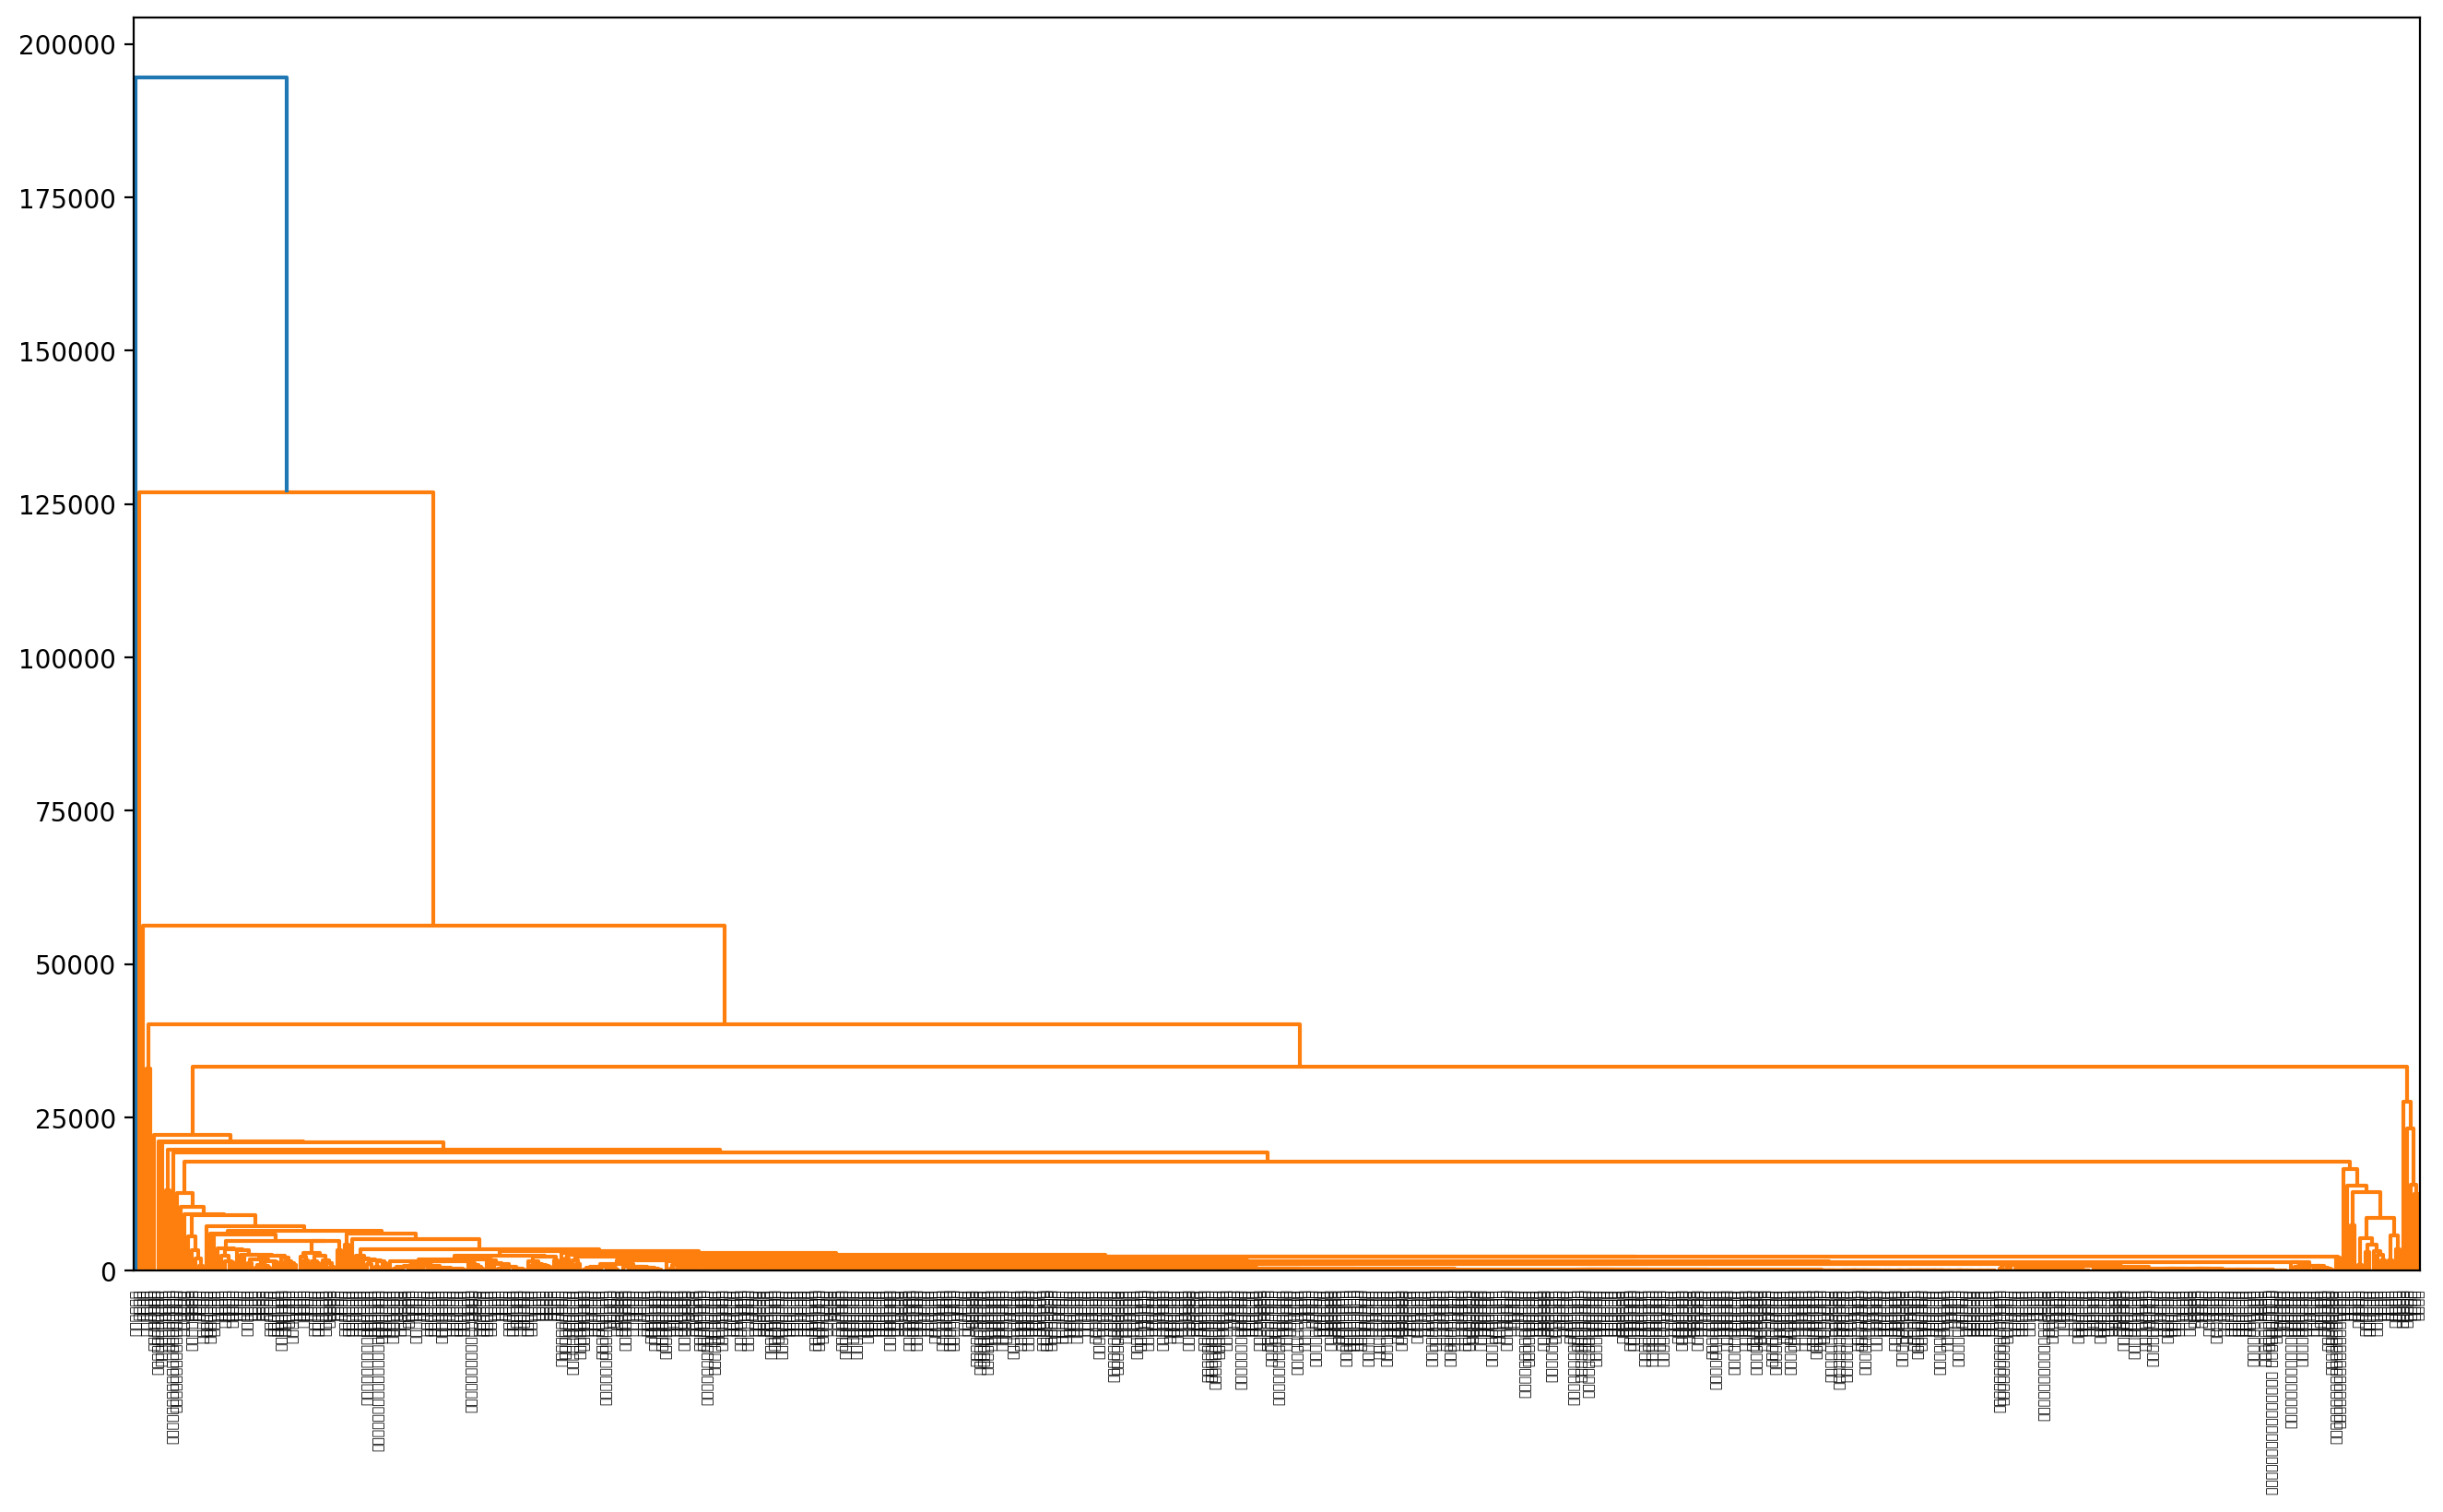

In [5]:
# 試しに階層型クラスタリングして、デンドログラムを書いてみる。あまり役に立たない？
# 階層型クラスタリング(ウォード法)
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
 
# linkage_result = linkage(pivot_orders_df2, method='ward', metric='euclidean')
linkage_result = linkage(pivot_orders_df2, method='average', metric='euclidean')
plt.figure(num=None, figsize=(16, 9), dpi=200, facecolor='w', edgecolor='k')
dendrogram(linkage_result, labels=pivot_orders_df2.index)
plt.show()
# 24.4s

# 階層型クラスタリング
+ ユークリッド距離とウォード法または群平均法を使用してクラスタリング
    + average:群平均法：クラスター分析で使用される、クラスター間の距離算出方法の一つ。 2つのクラスター間で可能な全ての組み合わせにおける非類似度の平均からクラスターを形成する方法。
## 結果
- 3 Index(['お茶の水女子大学', 'こども教育宝仙大学', 'つくば国際大学', 'びわこ成蹊スポーツ大学', 'ものつくり大学',
       'アジア成長研究所', 'デジタルハリウッド大学', 'ノートルダム清心女子大学', 'フェリス女学院大学', 'ヤマザキ動物看護大学',
       ...
       '鶴見大学', '鹿児島国際大学', '鹿児島大学', '鹿児島女子短期大学', '鹿児島県立短期大学', '鹿児島純心女子大学',
       '鹿児島純心女子短期大学', '鹿屋体育大学', '麗澤大学', '麻布大学'],
      dtype='object', name='institutions', length=602)
- 6 Index(['京都大学'], dtype='object', name='institutions')
- 4 Index(['北海道大学', '大阪大学', '早稲田大学', '東京大学', '筑波大学'], dtype='object', name='institutions')
- 5 Index(['千葉大学'], dtype='object', name='institutions')
- 1 Index(['慶應義塾大学'], dtype='object', name='institutions')
- 7 Index(['東京工業大学'], dtype='object', name='institutions')
- 2 Index(['東北大学'], dtype='object', name='institutions')

In [4]:
# 【python】scipyで階層型クラスタリングするときの知見まとめ
# https://www.haya-programming.com/entry/2019/02/11/035943#linkage
import numpy as np
from collections import defaultdict
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.datasets import load_digits

def gen_data():
    digits = load_digits()
    label_uniq = np.unique(digits.target)
    result = []
    for label in label_uniq:
        result.append(digits.data[digits.target == label].mean(axis=0))
    return result, label_uniq

def clustering_fcluster():
    X, y = gen_data()
    S = pdist(X)
    # methods = ["single", "complete", "average", "weighted", "centroid", "median", "ward"]
    # Z = linkage(pivot_orders_df2, metric='euclidean', method='ward')
    Z = linkage(pivot_orders_df2, metric='euclidean', method='average')
    # Z = linkage(pivot_orders_df2, method="average")
    # criterion= ‘maxclust’、最大クラスタ数
    # ’distance’ 距離で閾値を指定
    # inconsistent (default)
    # monocrit, maxclust_monocrit
    result = fcluster(Z, t=7, criterion="maxclust")
    # result = fcluster(Z, t=5, criterion="distance")
    d = defaultdict(list)
    for i, r in enumerate(result):
        d[r].append(i)
    for k, v in d.items():
        print(k, pivot_orders_df2.index[v])
        # print(k,v) # v は行番号のリスト
        
if __name__ == "__main__":
    clustering_fcluster()

3 Index(['お茶の水女子大学', 'こども教育宝仙大学', 'つくば国際大学', 'びわこ成蹊スポーツ大学', 'ものつくり大学',
       'アジア成長研究所', 'デジタルハリウッド大学', 'ノートルダム清心女子大学', 'フェリス女学院大学', 'ヤマザキ動物看護大学',
       ...
       '鶴見大学', '鹿児島国際大学', '鹿児島大学', '鹿児島女子短期大学', '鹿児島県立短期大学', '鹿児島純心女子大学',
       '鹿児島純心女子短期大学', '鹿屋体育大学', '麗澤大学', '麻布大学'],
      dtype='object', name='institutions', length=602)
6 Index(['京都大学'], dtype='object', name='institutions')
4 Index(['北海道大学', '大阪大学', '早稲田大学', '東京大学', '筑波大学'], dtype='object', name='institutions')
5 Index(['千葉大学'], dtype='object', name='institutions')
1 Index(['慶應義塾大学'], dtype='object', name='institutions')
7 Index(['東京工業大学'], dtype='object', name='institutions')
2 Index(['東北大学'], dtype='object', name='institutions')


In [10]:
# 行と列に合計値を追加する 
pivot_orders_df3 = pd.concat([pivot_orders_df2,pd.DataFrame(pivot_orders_df2.sum(axis=0),columns=['Grand Total']).T])
pivot_orders_df3 = pd.concat([pivot_orders_df2,pd.DataFrame(pivot_orders_df2.sum(axis=1),columns=['Total'])],axis=1)
pivot_orders_df3

,article,bachelor thesis,book,book part,cartographic material,conference object,conference paper,conference poster,conference proceedings,data paper,...,report part,research report,review article,software,sound,still image,technical report,thesis,working paper,Total
institutions,,,,,,,,,,,,,,,,,,,,,
お茶の水女子大学,17818,0,55,0,0,61,133,0,0,0,...,0,619,0,0,0,0,0,0,0,39468
こども教育宝仙大学,0,0,3,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,162
つくば国際大学,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,569
びわこ成蹊スポーツ大学,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,125,2062,0,2944
ものつくり大学,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
鹿児島純心女子大学,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,445
鹿児島純心女子短期大学,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,103
鹿屋体育大学,0,0,0,0,0,0,0,0,0,0,...,0,230,0,0,0,0,0,33,0,1158


In [11]:
# Totalの降順にソートする
pivot_orders_df4 = pivot_orders_df3.sort_values(by='Total', ascending=False) 
# 日付をファイル名にしてエクセルに出力
import datetime
now = datetime.datetime.now()
filename = './irdbscraping_' + now.strftime('%Y%m%d_%H%M%S') + '.xlsx'
pivot_orders_df4.to_excel('./'+filename, sheet_name='filename')

In [12]:
pivot_orders_df4.columns

Index(['article', 'bachelor thesis', 'book', 'book part',
       'cartographic material', 'conference object', 'conference paper',
       'conference poster', 'conference proceedings', 'data paper', 'dataset',
       'departmental bulletin paper', 'doctoral thesis', 'editorial', 'image',
       'interview', 'journal article', 'learning object', 'lecture',
       'manuscript', 'master thesis', 'musical notation', 'newspaper', 'other',
       'periodical', 'report', 'report part', 'research report',
       'review article', 'software', 'sound', 'still image',
       'technical report', 'thesis', 'working paper', 'Total'],
      dtype='object')

In [13]:
# 合計 Total の概要
print(pivot_orders_df4.describe(percentiles=[0.2, 0.4, 0.6, 0.8,0.95]).loc[:,"Total"])

count       612.000000
mean       4921.506536
std       18220.891731
min           1.000000
20%         235.000000
40%         615.800000
50%         875.500000
60%        1395.200000
80%        3972.400000
95%       19454.200000
max      309580.000000
Name: Total, dtype: float64


<AxesSubplot:title={'center':'機関ごと件数の合計値でヒストグラム'}, xlabel='機関ごとの件数', ylabel='機関数'>

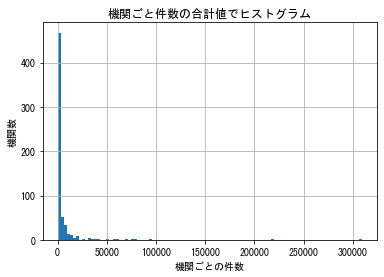

In [14]:
# ヒストグラム'
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "MS Gothic"
# タイトル追加
plt.title('機関ごと件数の合計値でヒストグラム')
# x軸にscore、y軸にfreq
plt.xlabel('機関ごとの件数')
plt.ylabel('機関数')
# 目盛りを変更
# plt.ylim(0, 190)
# plt.xticks([0,10,20,30,40,50,60,70,80,90,100]) 
# ヒストグラムを描画する（表示する幅は50〜100）、階級数（棒の数）は20
# plt.hist(pivot_orders_df4['Total'], range=(00, 100), bins=10)
pivot_orders_df4['Total'].hist(bins=100) # histogramを出すだけならこちらでもよい
# '紀要の百分率でヒストグラム'
# plt.hist(kiyou['journal article'], range=(00, 100), bins=10)

In [15]:
# 度数分布表を一発で自動生成
# https://qiita.com/TakuTaku36/items/91032625e482f2ae6e18
import numpy as np
# def Frequency_Distribution(data, class_width=None):
def Frequency_Distribution(data, class_width):
    data = np.asarray(data)
    if class_width is None:
        class_size = int(np.log2(data.size).round()) + 1
        class_width = round((data.max() - data.min()) / class_size)

    bins = np.arange(0, data.max()+class_width+1, class_width)
    hist = np.histogram(data, bins)[0]
    cumsum = hist.cumsum()

    return pd.DataFrame({'階級値': (bins[1:] + bins[:-1]) / 2,
                         '度数': hist,
                         '累積度数': cumsum,
                         '相対度数': hist / cumsum[-1],
                         '累積相対度数': cumsum / cumsum[-1]},
                        index=pd.Index([f'{bins[i]}以上{bins[i+1]}未満'
                                        for i in range(hist.size)],
                                       name='階級'))
x = list(pivot_orders_df4['Total'])
# x = [0, 3, 3, 5, 5, 5, 5, 7, 7, 10, 11, 14, 14, 14]
class_width = None #を指定すると自動
Frequency_Distribution(x,class_width)

,階級値,度数,累積度数,相対度数,累積相対度数
階級,,,,,
0以上30958未満,15479.0,591,591,0.965686,0.965686
30958以上61916未満,46437.0,14,605,0.022876,0.988562
61916以上92874未満,77395.0,4,609,0.006536,0.995098
92874以上123832未満,108353.0,1,610,0.001634,0.996732
123832以上154790未満,139311.0,0,610,0.000000,0.996732
154790以上185748未満,170269.0,0,610,0.000000,0.996732
185748以上216706未満,201227.0,0,610,0.000000,0.996732
216706以上247664未満,232185.0,1,611,0.001634,0.998366
247664以上278622未満,263143.0,0,611,0.000000,0.998366


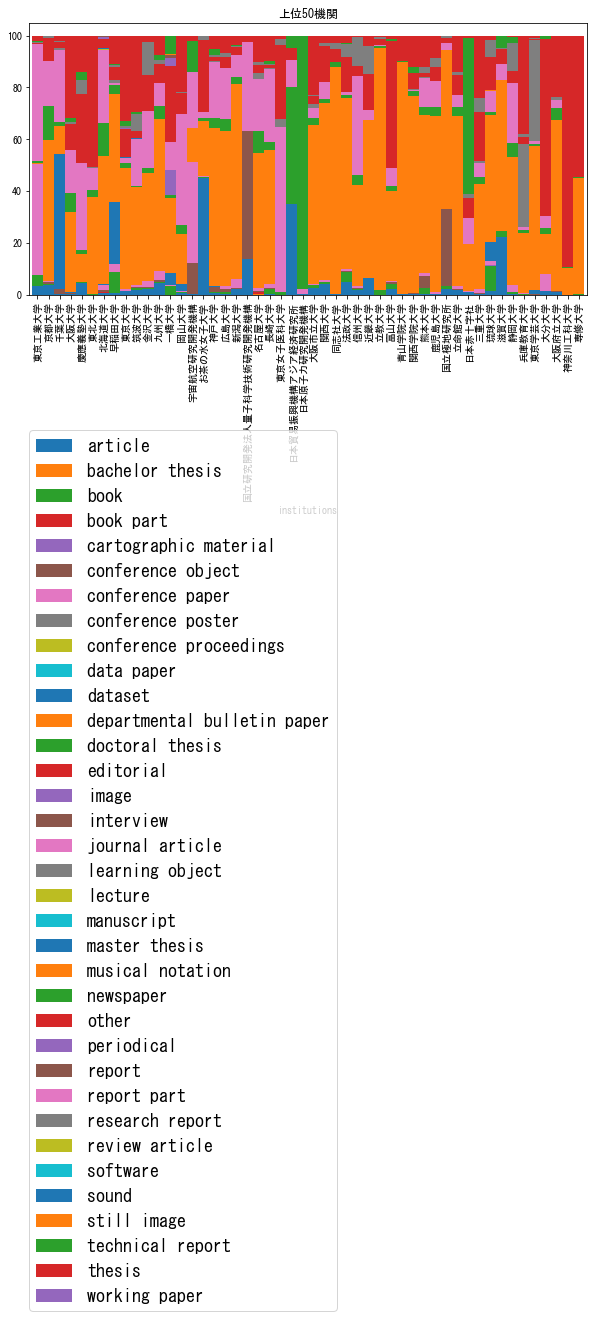

In [16]:
# コンテンツ数上位50機関で構成比率の帯グラフ化
# グラフの文字化け対策
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams["font.family"] = "MS Gothic"
# df.iloc[:, 1:] = df.iloc[:, 1:].div(df['total'], axis=0).mul(100).round(2).astype(str).add(' %')
# 行ごとの百分率に変換する
pivot_orders_df5 = pivot_orders_df4.div(pivot_orders_df4['Total'], axis=0).mul(100)  # .round(2) 四捨五入
# df.drop("b", axis=1)
# pivot_orders_df5.iloc[:50,].drop("Total", axis=1).plot.bar(stacked=True)  
# .iloc[:12,] 12機関目までにする
# 判例の位置調整　https://qiita.com/matsui-k20xx/items/291400ed56a39ed63462
pivot_orders_df5.iloc[:50,].drop("Total", axis=1)\
    .plot(kind='bar', stacked=True, figsize=(10,5), width=1, linewidth=0,title='上位50機関',)\
    .legend(bbox_to_anchor=(0, -0.5), loc='upper left', borderaxespad=0, fontsize=18)

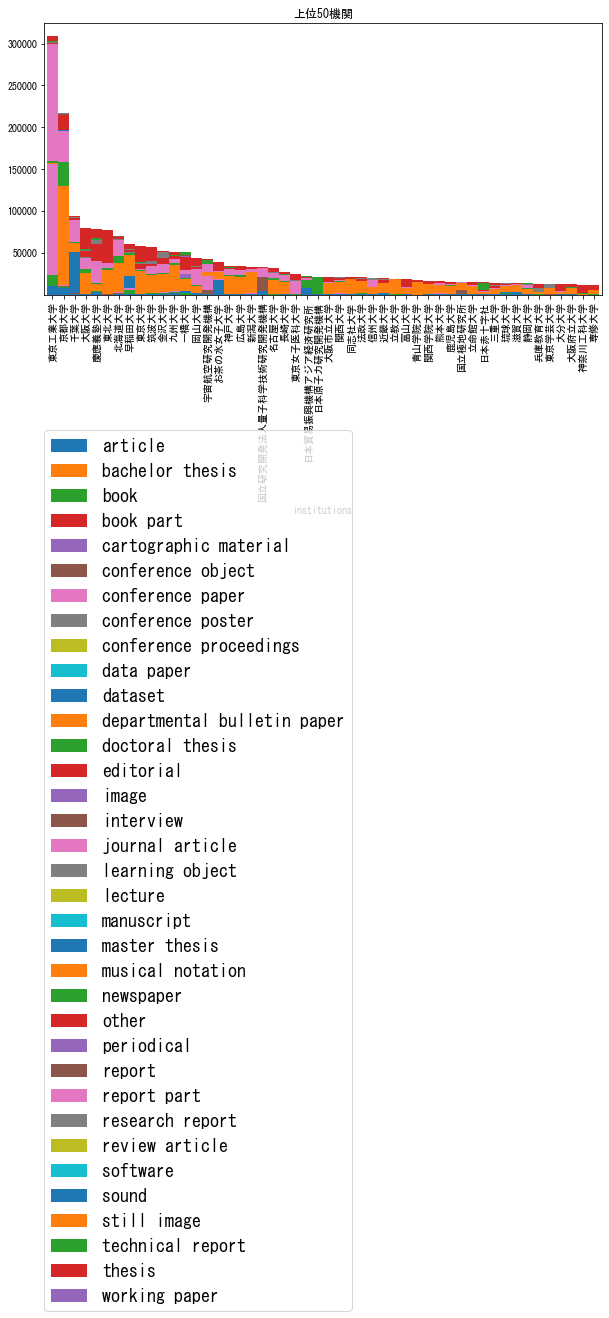

In [17]:
# コンテンツ数上位50機関で構成比率の積み上げグラフ化
# グラフの文字化け対策
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams["font.family"] = "MS Gothic"
# .iloc[:12,] 12機関目までにする
# 判例の位置調整　https://qiita.com/matsui-k20xx/items/291400ed56a39ed63462
pivot_orders_df4.iloc[:50,].drop("Total", axis=1)\
    .plot(kind='bar', stacked=True, figsize=(10,5), width=1, linewidth=0,title='上位50機関',)\
    .legend(bbox_to_anchor=(0, -0.5), loc='upper left', borderaxespad=0, fontsize=18)
   
# iloc() を使って 列をスライスする
# pivot_orders_df5.iloc[:12, 0:34].plot.bar(stacked=True)
# pivot_orders_df5.loc[:12, 'article':'working paper'].plot.bar(stacked=True)
# 4.6s

# 各列のヒストグラムを作成
+ 資料タイプ別百分率の各列でヒストグラムを作成
+ 紀要['departmental bulletin paper']以外には、ほとんど特徴がないことが分かる。

C:\Users\onowa\AppData\Local\Temp/ipykernel_6480/201650576.py:7: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  pivot_orders_df5.hist(ax=ax)


array([[<AxesSubplot:title={'center':'article'}>,
        <AxesSubplot:title={'center':'bachelor thesis'}>,
        <AxesSubplot:title={'center':'book'}>,
        <AxesSubplot:title={'center':'book part'}>,
        <AxesSubplot:title={'center':'cartographic material'}>,
        <AxesSubplot:title={'center':'conference object'}>],
       [<AxesSubplot:title={'center':'conference paper'}>,
        <AxesSubplot:title={'center':'conference poster'}>,
        <AxesSubplot:title={'center':'conference proceedings'}>,
        <AxesSubplot:title={'center':'data paper'}>,
        <AxesSubplot:title={'center':'dataset'}>,
        <AxesSubplot:title={'center':'departmental bulletin paper'}>],
       [<AxesSubplot:title={'center':'doctoral thesis'}>,
        <AxesSubplot:title={'center':'editorial'}>,
        <AxesSubplot:title={'center':'image'}>,
        <AxesSubplot:title={'center':'interview'}>,
        <AxesSubplot:title={'center':'journal article'}>,
        <AxesSubplot:title={'center':'lear

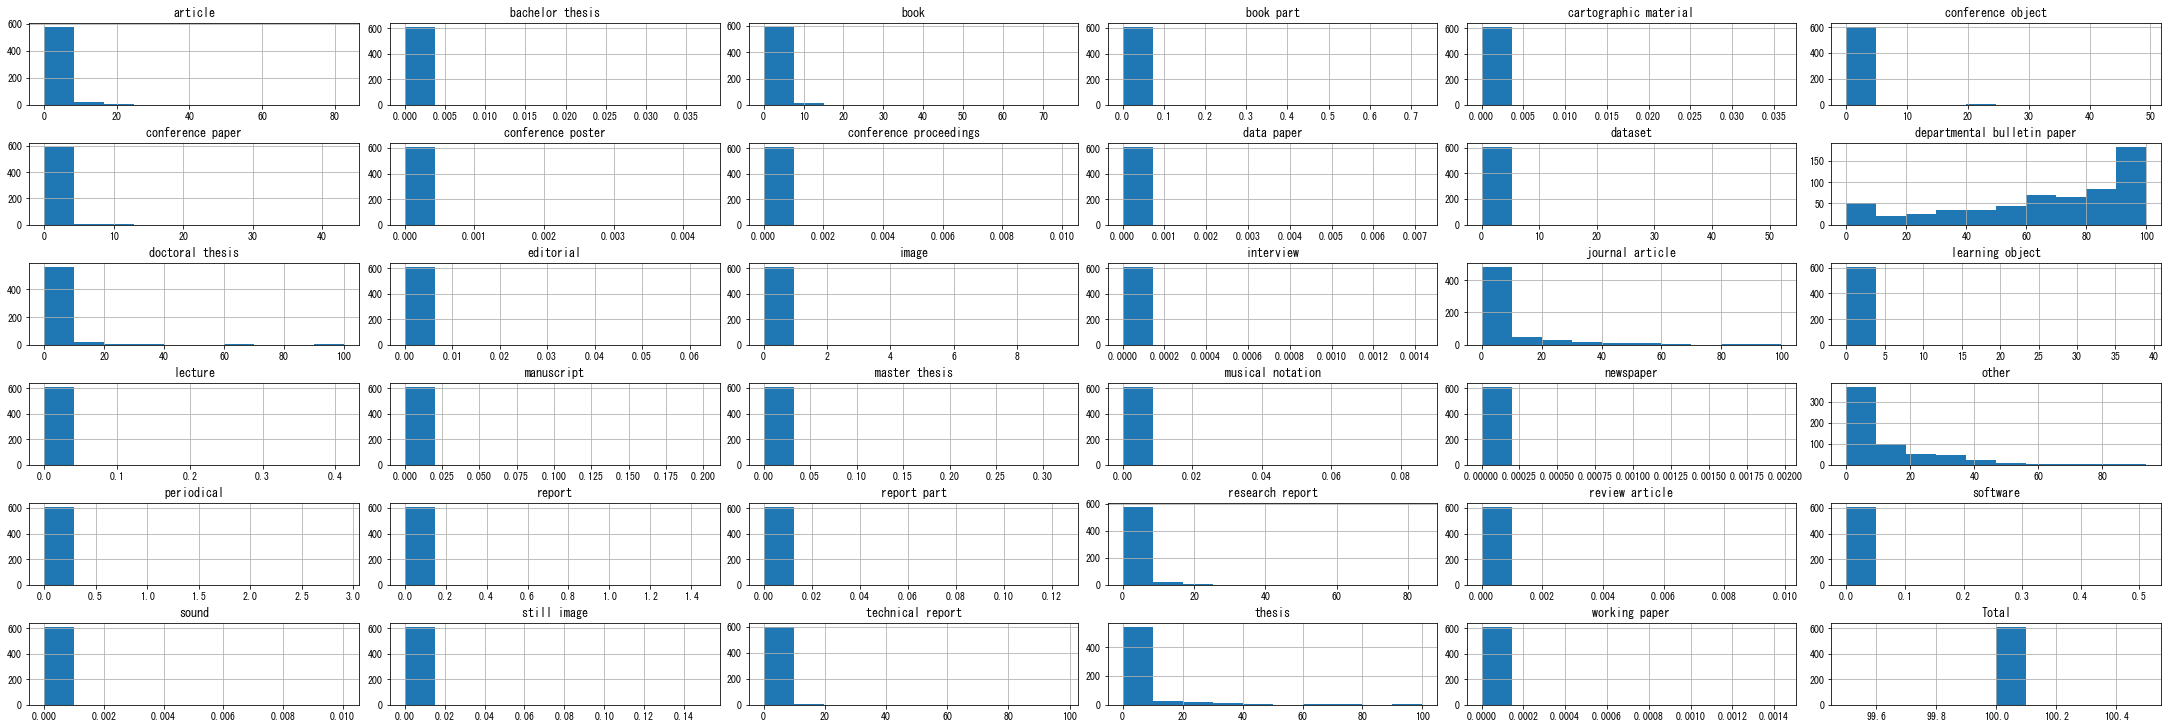

In [28]:
# 各列のヒストグラムを作成
plt.rcParams['font.size'] = 10
# fig = plt.subplots_adjust(wspace=10.4, hspace=10.6)
fig, ax = plt.subplots(figsize=(30,10), constrained_layout=True)
# plt.subplots_adjust(wspace=0.4, hspace=1.6)
# pivot_orders_df5 は 行ごとの百分率に変換したDataFrame
pivot_orders_df5.hist(ax=ax)
fig.savefig("img.png")
# 6.7s

# 紀要の構成比でヒストグラムを作成

institutions
岡山商科大学         100.000000
秋田工業高等専門学校     100.000000
湘北短期大学         100.000000
大阪国際大学         100.000000
神戸医療福祉大学       100.000000
                  ...    
大阪経済法科大学        99.090909
佐世保工業高等専門学校     99.085714
神田外語大学          99.061327
会津大学短期大学部       99.046484
白梅学園大学          99.026764
Name: departmental bulletin paper, Length: 62, dtype: float64


(array([ 50.,  21.,  26.,  35.,  35.,  44.,  69.,  64.,  85., 183.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

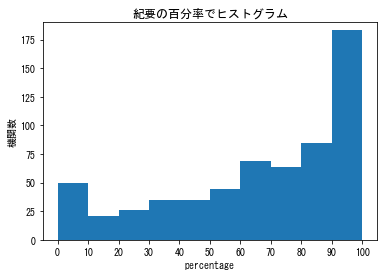

In [10]:

# 紀要['departmental bulletin paper']の個数でソートしたものを kiyou とする
kiyou = pivot_orders_df5.sort_values(by='departmental bulletin paper', ascending=False) 
# 紀要が90%以上　>90 のもの
print(kiyou['departmental bulletin paper'][kiyou['departmental bulletin paper'] > 99])  #  == 100
# kiyou['departmental bulletin paper'].hist(bins=20) # histogramを出すだけならこちらでもよい
# '紀要の百分率でヒストグラム'
import matplotlib.pyplot as plt
# タイトル追加
plt.title('紀要の百分率でヒストグラム')
# x軸にscore、y軸にfreq
plt.xlabel('percentage')
plt.ylabel('機関数')
# 目盛りを変更
plt.ylim(0, 190)
plt.xticks([0,10,20,30,40,50,60,70,80,90,100]) 
# ヒストグラムを描画する（表示する幅は50〜100）、階級数（棒の数）は20
plt.hist(kiyou['departmental bulletin paper'], range=(00, 100), bins=10)
# plt.hist(kiyou['journal article'], range=(00, 100), bins=10)

# 紀要の度数分布表
+ 紀要のみ（100%）の機関が5%（32機関）
+ 紀要の構成比で80%以上の機関が43%以上（268機関）

In [12]:
# 度数分布表を一発で自動生成
# https://qiita.com/TakuTaku36/items/91032625e482f2ae6e18
import numpy as np
def Frequency_Distribution(data, class_width=None):
    data = np.asarray(data)
    if class_width is None:
        class_size = int(np.log2(data.size).round()) + 1
        class_width = round((data.max() - data.min()) / class_size)

    bins = np.arange(0, data.max()+class_width+1, class_width)
    hist = np.histogram(data, bins)[0]
    cumsum = hist.cumsum()

    return pd.DataFrame({'階級値': (bins[1:] + bins[:-1]) / 2,
                         '度数': hist,
                         '累積度数': cumsum,
                         '相対度数': hist / cumsum[-1],
                         '累積相対度数': cumsum / cumsum[-1]},
                        index=pd.Index([f'{bins[i]}以上{bins[i+1]}未満'
                                        for i in range(hist.size)],
                                       name='階級'))
x = list(kiyou['departmental bulletin paper'])
# x = [0, 3, 3, 5, 5, 5, 5, 7, 7, 10, 11, 14, 14, 14]
Frequency_Distribution(x)

,階級値,度数,累積度数,相対度数,累積相対度数
階級,,,,,
0.0以上10.0未満,5.0,50,50,0.081699,0.081699
10.0以上20.0未満,15.0,21,71,0.034314,0.116013
20.0以上30.0未満,25.0,26,97,0.042484,0.158497
30.0以上40.0未満,35.0,35,132,0.057190,0.215686
40.0以上50.0未満,45.0,35,167,0.057190,0.272876
50.0以上60.0未満,55.0,44,211,0.071895,0.344771
60.0以上70.0未満,65.0,69,280,0.112745,0.457516
70.0以上80.0未満,75.0,64,344,0.104575,0.562092
80.0以上90.0未満,85.0,85,429,0.138889,0.700980


# 雑誌論文
+ 雑誌論文の構成比率が100%の機関（桃山学院教育大学）は、機関全体で全3件でかつ、中身は紀要のようだ
+ 98%の國學院大學は、学内学会的なものを雑誌論文としている
+ 97%の国立社会保障・人口問題研究所は、自機関発行の雑誌、working paper を含んでいる
+ 沖縄科学技術大学院大学は、いわゆる典型的なGreen OA論文が多い

institutions
桃山学院教育大学          100.000000
國學院大學              98.387097
国立社会保障・人口問題研究所     97.252747
東北福祉大学             93.648649
川崎医科大学             93.533887
沖縄科学技術大学院大学        93.505633
Name: journal article, dtype: float64


(array([483.,  46.,  27.,  18.,   9.,  11.,   7.,   1.,   4.,   6.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

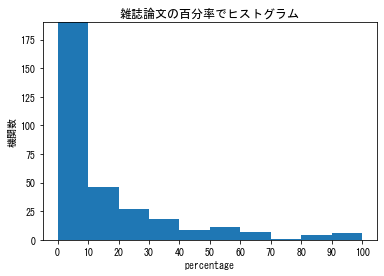

In [59]:

# 雑誌論文['journal article']の個数でソートしたものを joua とする
joua = pivot_orders_df5.sort_values(by='journal article', ascending=False) 
# 紀要が90%以上　>90 のもの
print(joua['journal article'][joua['journal article'] >= 90])  #  == 100
# kiyou['departmental bulletin paper'].hist(bins=20) # これが単純でよい
# '雑誌論文の百分率でヒストグラム'
import matplotlib.pyplot as plt
# タイトル追加
plt.title('雑誌論文の百分率でヒストグラム')
# x軸にscore、y軸にfreq
plt.xlabel('percentage')
plt.ylabel('機関数')
# 目盛りを変更
plt.ylim(0, 190)
plt.xticks([0,10,20,30,40,50,60,70,80,90,100]) 
# ヒストグラムを描画する（表示する幅は50〜100）、階級数（棒の数）は20
plt.hist(joua['journal article'], range=(00, 100), bins=10)
# plt.hist(kiyou['journal article'], range=(00, 100), bins=10)

# 一旦保存

In [13]:
pivot_orders_df5.to_pickle('./pivot_orders_df5.pkl.gz', compression='gzip') # 圧縮有り
# pd.read_pickle('test.pkl.gz', compression='gzip') # 圧縮有り

In [2]:
# 前回保存したDataFrameのファイルから読み込む
import pandas as pd
# pivot_orders_df5 は行ごとの百分率に変換したDF
pivot_orders_df5 = pd.read_pickle('./pivot_orders_df5.pkl.gz', compression='gzip') # 圧縮有り

In [3]:
pivot_orders_df5

,article,bachelor thesis,book,book part,cartographic material,conference object,conference paper,conference poster,conference proceedings,data paper,...,report part,research report,review article,software,sound,still image,technical report,thesis,working paper,Total
institutions,,,,,,,,,,,,,,,,,,,,,
東京工業大学,3.267653,0.0,4.106531,0.000000,0.0,0.000000,43.154274,0.0,0.0,0.0,...,0.0,0.554622,0.0,0.003230,0.0,0.0,0.208670,2.258221,0.0,100.0
京都大学,3.744404,0.0,0.430191,0.017925,0.0,0.490858,0.631957,0.0,0.0,0.0,...,0.0,1.035031,0.0,0.001379,0.0,0.0,0.005975,0.000000,0.0,100.0
千葉大学,0.005315,0.0,0.138201,0.000000,0.0,1.942253,0.095678,0.0,0.0,0.0,...,0.0,0.570876,0.0,0.000000,0.0,0.0,0.064848,1.966704,0.0,100.0
大阪大学,0.023926,0.0,0.237999,0.000000,0.0,0.158666,0.314814,0.0,0.0,0.0,...,0.0,0.562887,0.0,0.000000,0.0,0.0,1.868735,31.657684,0.0,100.0
慶應義塾大学,4.328538,0.0,0.503885,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,5.672231,0.0,0.000000,0.0,0.0,3.016899,14.042106,0.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
公立諏訪東京理科大学,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,100.0
常磐大学,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,100.0
釧路公立大学,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,25.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,100.0


# 構成比率（百分率）で階層的クラスタリング

In [61]:
# 構成比率（百分率）で階層的クラスタリング
# 【python】scipyで階層型クラスタリングするときの知見まとめ
# https://www.haya-programming.com/entry/2019/02/11/035943#linkage
# pivot_orders_df2 は実数値で、合計列/行がないDF
import numpy as np
from collections import defaultdict
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.datasets import load_digits

def gen_data():
    digits = load_digits()
    label_uniq = np.unique(digits.target)
    result = []
    for label in label_uniq:
        result.append(digits.data[digits.target == label].mean(axis=0))
    return result, label_uniq

def clustering_fcluster():
    X, y = gen_data()
    S = pdist(X)
    # methods = ["single", "complete", "average", "weighted", "centroid", "median", "ward"]
    Z = linkage(pivot_orders_df2, metric='euclidean', method='complete')
    # Z = linkage(pivot_orders_df2, metric='euclidean', method='ward')
    # Z = linkage(pivot_orders_df4, metric='euclidean', method='average')
    # Z = linkage(pivot_orders_df2, method="average")
    # criterion= ‘maxclust’、最大クラスタ数
    # ’distance’ 距離で閾値を指定
    # inconsistent (default)
    # monocrit, maxclust_monocrit
    result = fcluster(Z, t=10, criterion="maxclust")
    # result = fcluster(Z, t=5, criterion="distance")
    d = defaultdict(list)
    for i, r in enumerate(result):
        d[r].append(i)
    cluster_list = []
    for k, v in d.items():
        # print(k, pivot_orders_df2.index[v])
        cluster_list.append(pivot_orders_df2.index[v])
        # print(k,v) # v は行番号のリスト
    return cluster_list
    
if __name__ == "__main__":
    cluster_list = clustering_fcluster()
    print(cluster_list)

[Index(['お茶の水女子大学', 'こども教育宝仙大学', 'つくば国際大学', 'びわこ成蹊スポーツ大学', 'ものつくり大学',
       'アジア成長研究所', 'デジタルハリウッド大学', 'ノートルダム清心女子大学', 'フェリス女学院大学', 'ヤマザキ動物看護大学',
       ...
       '鶴見大学', '鹿児島国際大学', '鹿児島大学', '鹿児島女子短期大学', '鹿児島県立短期大学', '鹿児島純心女子大学',
       '鹿児島純心女子短期大学', '鹿屋体育大学', '麗澤大学', '麻布大学'],
      dtype='object', name='institutions', length=581), Index(['一橋大学', '九州大学', '同志社大学', '名古屋大学', '大阪市立大学', '広島大学', '新潟大学', '早稲田大学',
       '法政大学', '神戸大学', '立教大学', '近畿大学', '金沢大学', '長崎大学', '関西大学', '関西学院大学',
       '青山学院大学'],
      dtype='object', name='institutions'), Index(['京都大学'], dtype='object', name='institutions'), Index(['北海道大学'], dtype='object', name='institutions'), Index(['千葉大学'], dtype='object', name='institutions'), Index(['国立研究開発法人量子科学技術研究開発機構', '宇宙航空研究開発機構', '日本原子力研究開発機構'], dtype='object', name='institutions'), Index(['大阪大学', '東京大学', '筑波大学'], dtype='object', name='institutions'), Index(['岡山大学', '慶應義塾大学', '東京女子医科大学'], dtype='object', name='institutions'), Index(['東京工業大学'], dtype='object', name='inst

In [43]:
# print(cluster_list[0])
pivot_orders_df5.loc[['岡山大学', '慶應義塾大学', '東京女子医科大学'],'journal article']

institutions
岡山大学        42.856811
慶應義塾大学      33.694900
東京女子医科大学    63.550580
Name: journal article, dtype: float64

# 構成比率で階層的クラスタリングした結果ごとに帯グラフを描く
+ '階層的クラスタ別構成比_6' は学位論文と紀要が半々ぐらいのクラスターか？
+ '階層的クラスタ別構成比_7' はデータセットが多めのクラスター
+ それ以外の多数のところはそれほどクラスターに特徴がないように見える
+ 個数１のクラスタはそれぞれ特徴はある。

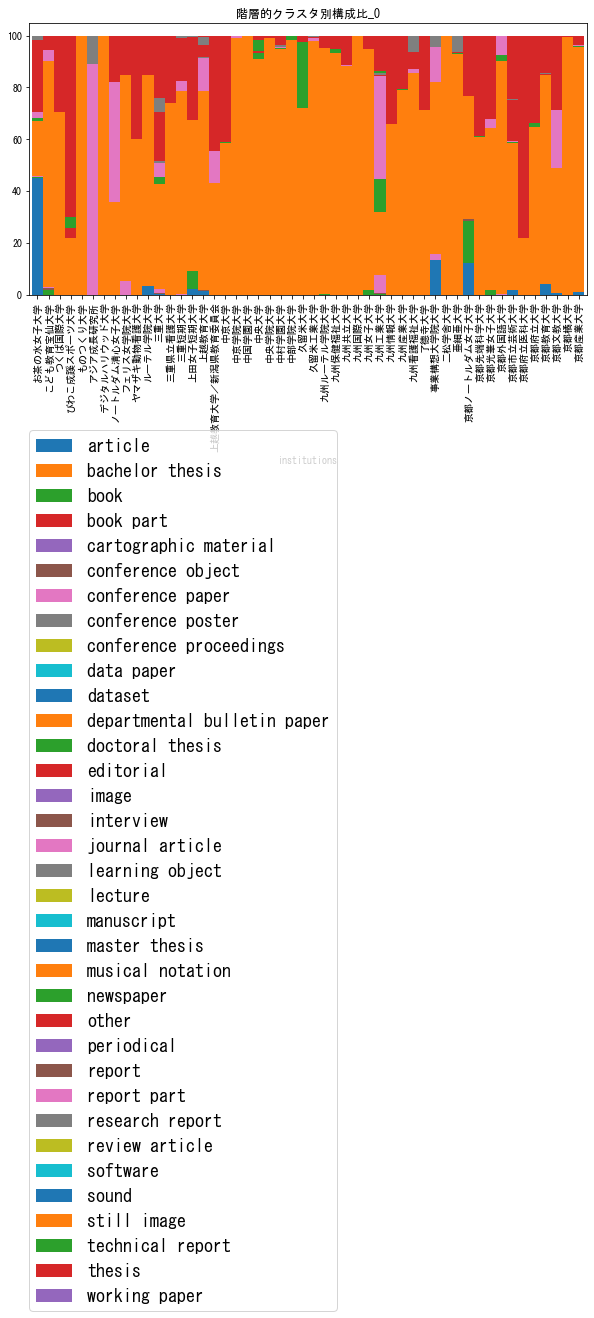

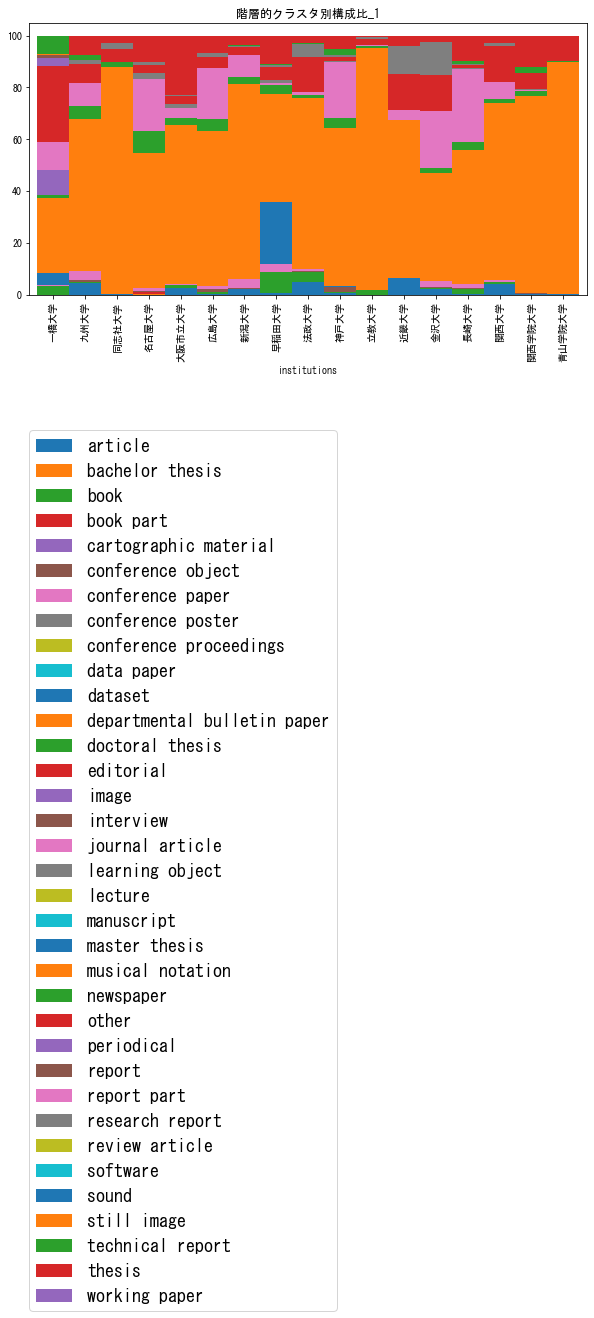

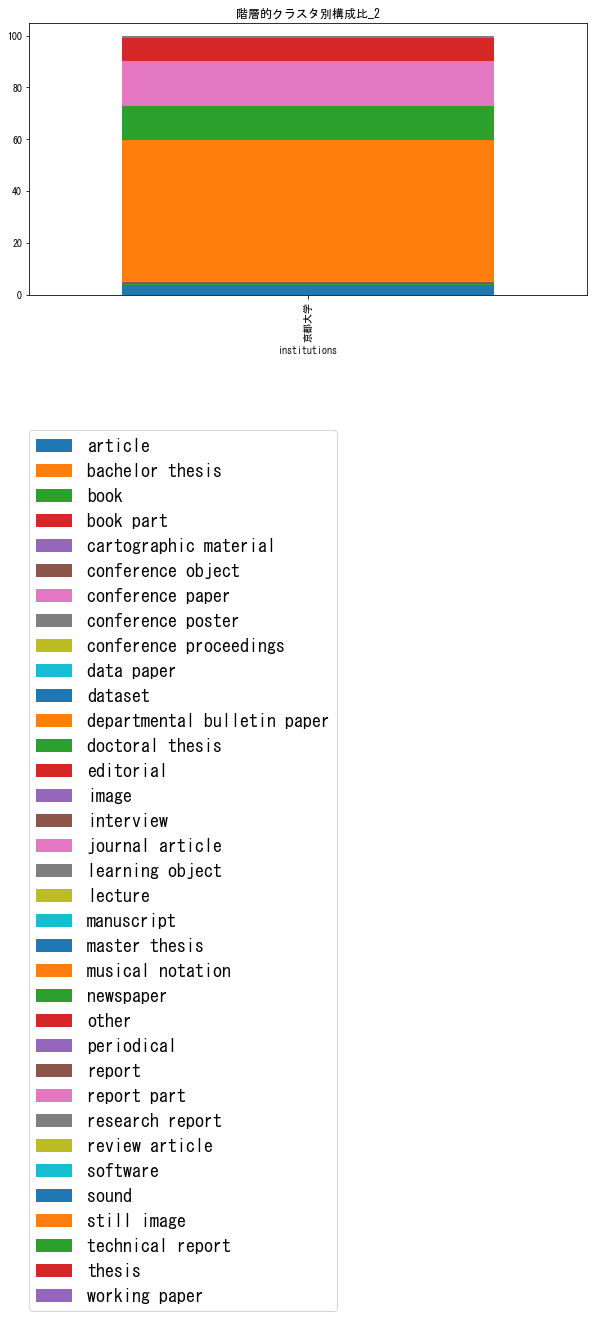

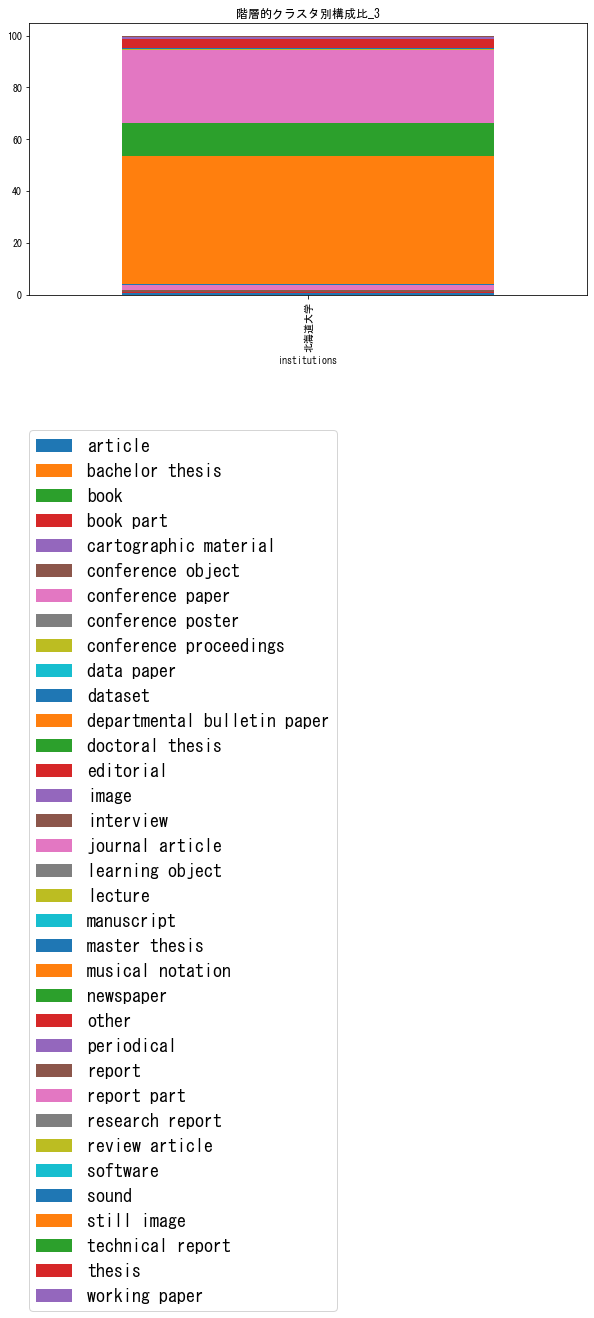

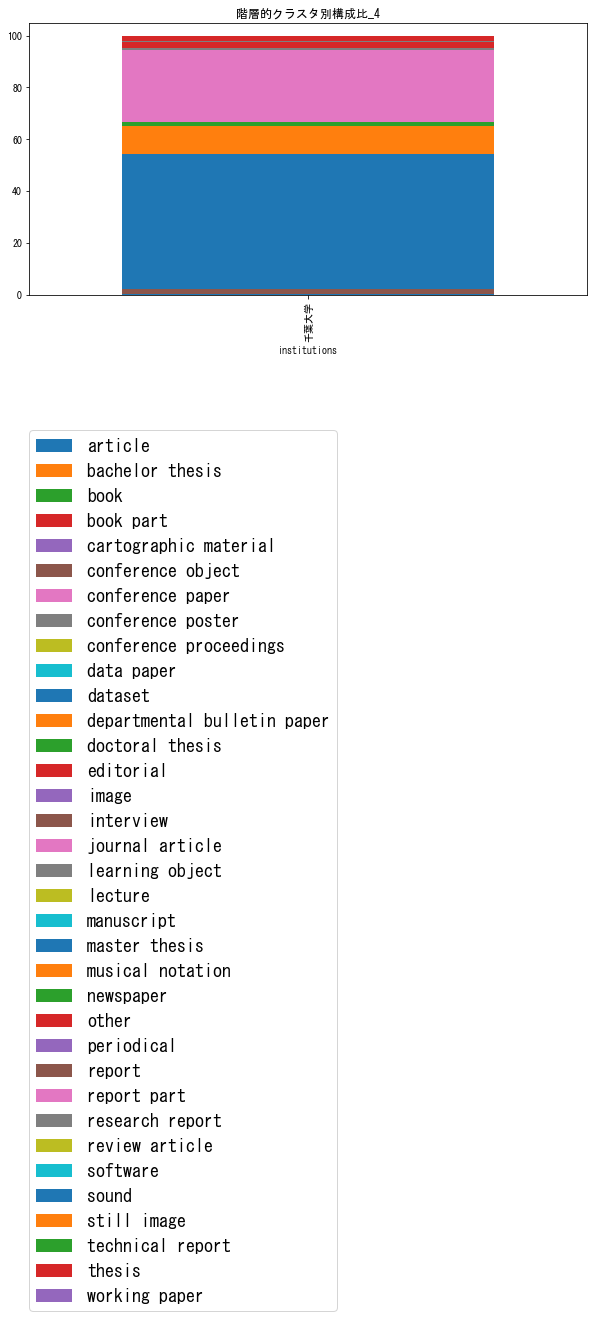

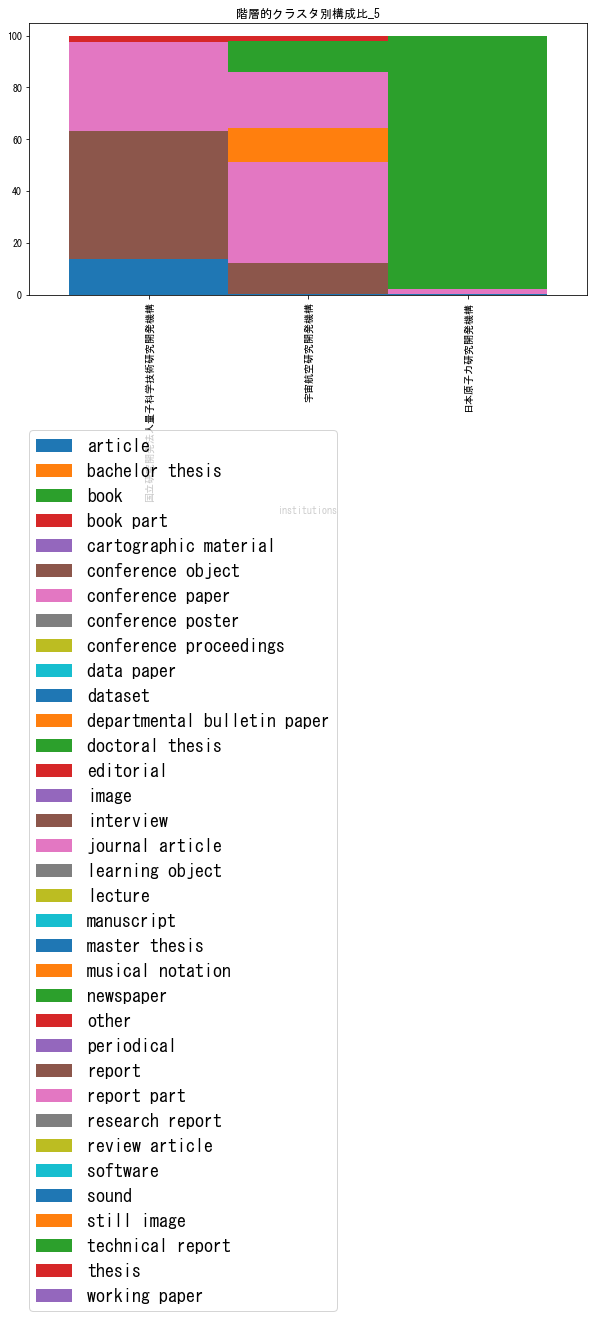

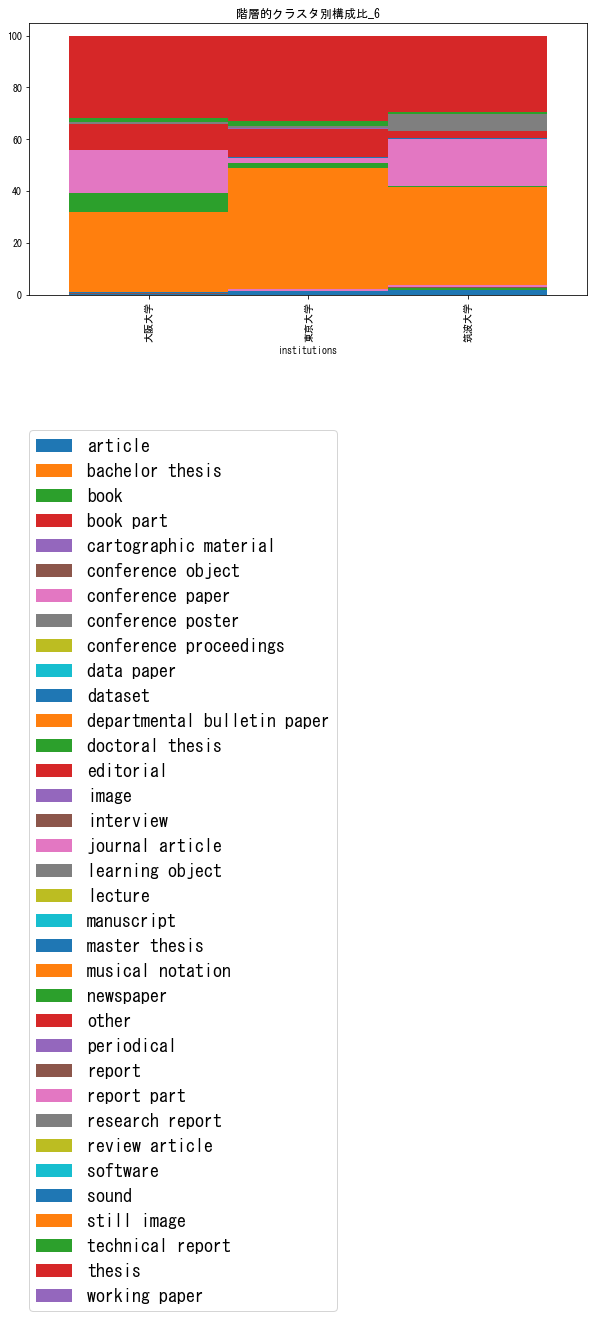

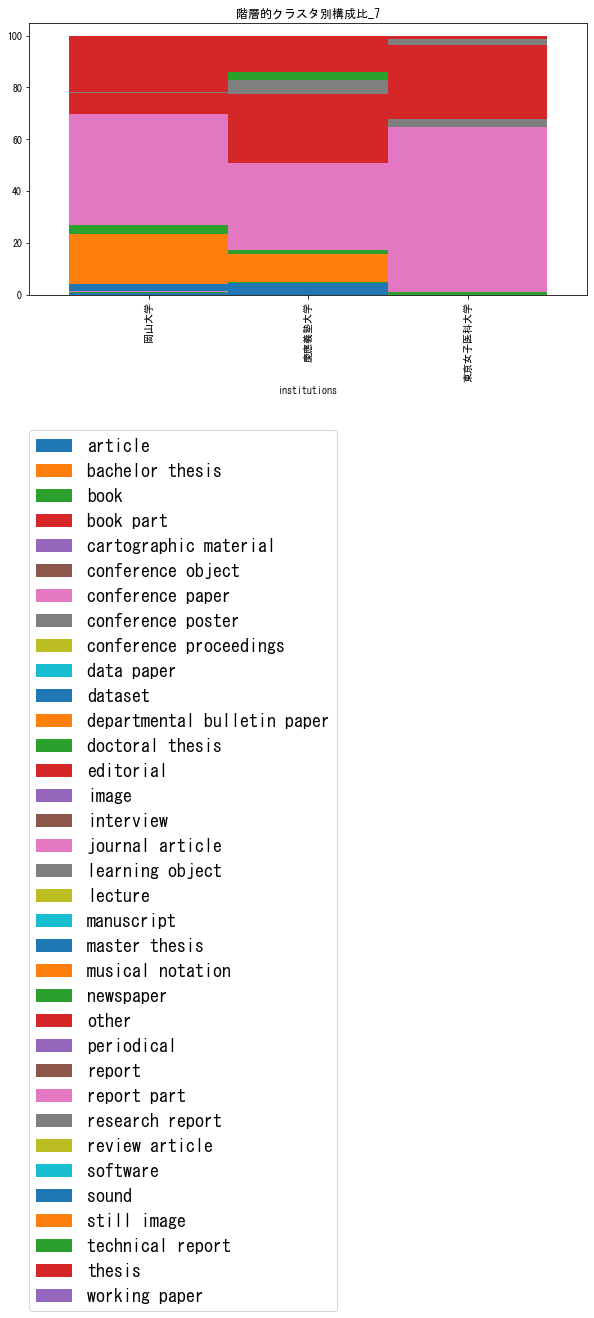

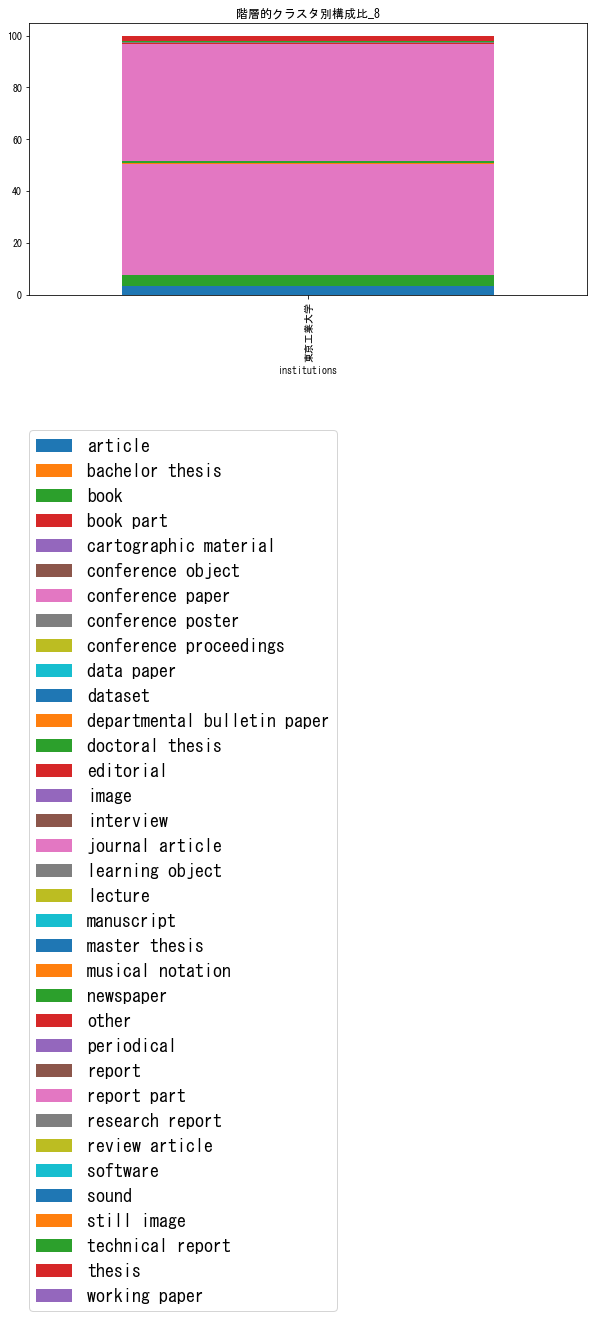

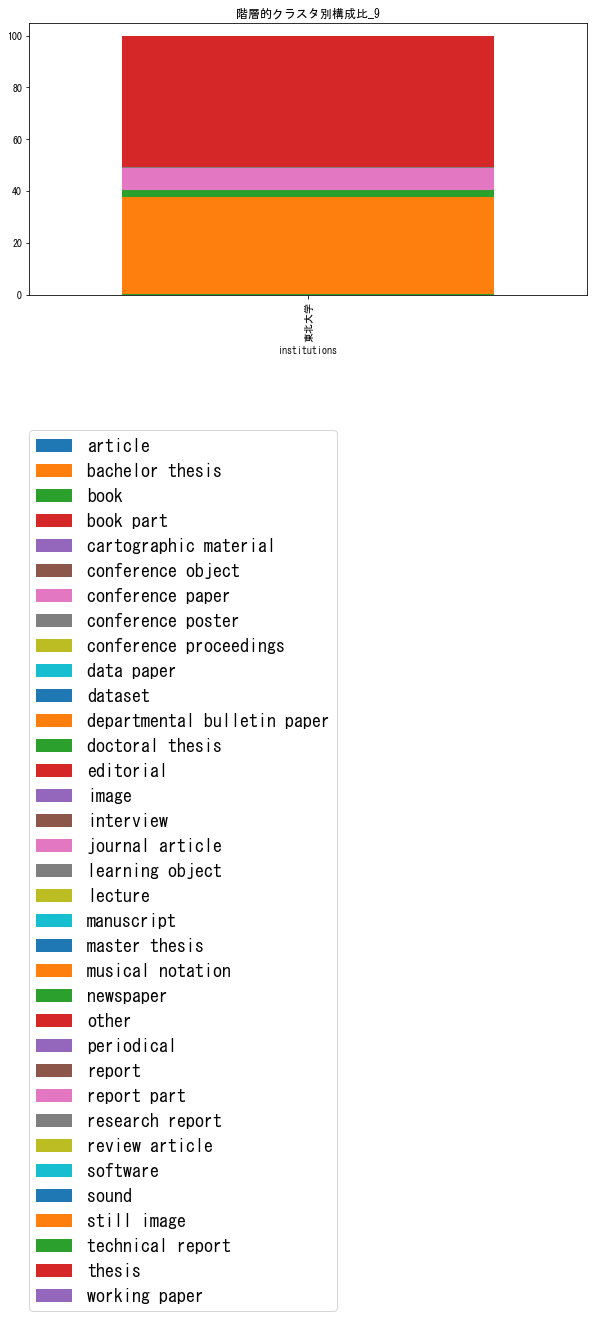

In [62]:
# コンテンツ数上位50機関で構成比率の帯グラフ化
# グラフの文字化け対策
from matplotlib import rcParams
plt.rcParams["font.family"] = "MS Gothic"
# df.iloc[:, 1:] = df.iloc[:, 1:].div(df['total'], axis=0).mul(100).round(2).astype(str).add(' %')
# 行ごとの百分率に変換する
# pivot_orders_df5は読み込み済み！# pivot_orders_df5 = pivot_orders_df4.div(pivot_orders_df4['Total'], axis=0).mul(100)  # .round(2) 四捨五入
# df.drop("b", axis=1)
# pivot_orders_df5.iloc[:50,].drop("Total", axis=1).plot.bar(stacked=True)  
# .iloc[:12,] 12機関目までにする
# 判例の位置調整　https://qiita.com/matsui-k20xx/items/291400ed56a39ed63462
# cluster1 = pivot_orders_df5.loc[['岡山大学', '慶應義塾大学', '東京女子医科大学']]
# cluster3 = pivot_orders_df5.loc[cluster_list[0]]
# cluster3.iloc[:50,].drop("Total", axis=1)\
for i, clust in enumerate(cluster_list):
   pivot_orders_df5.loc[clust].iloc[:50,].drop("Total", axis=1)\
    .plot(kind='bar', stacked=True, figsize=(10,5), width=1, linewidth=0,title='階層的クラスタ別構成比_'+str(i),)\
    .legend(bbox_to_anchor=(0, -0.5), loc='upper left', borderaxespad=0, fontsize=18)
   
# iloc() を使って 列をスライスする
# pivot_orders_df5.iloc[:12, 0:34].plot.bar(stacked=True)
# pivot_orders_df5.loc[:12, 'article':'working paper'].plot.bar(stacked=True)

In [16]:
pivot_orders_df4.tail()

,article,bachelor thesis,book,book part,cartographic material,conference object,conference paper,conference poster,conference proceedings,data paper,...,report part,research report,review article,software,sound,still image,technical report,thesis,working paper,Total
institutions,,,,,,,,,,,,,,,,,,,,,
公立諏訪東京理科大学,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
常磐大学,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
釧路公立大学,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,4
国立環境研究所,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
明治国際医療大学,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


# 元の数値（百分率でなく）各列のヒストグラムを作成
+ 資料タイプ別数値の各列でヒストグラムを作成
+ まったく特徴がでないことが分かる。

<ipython-input-11-cd79e501d91f>:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  pivot_orders_df4.hist(ax=ax)


array([[<AxesSubplot:title={'center':'article'}>,
        <AxesSubplot:title={'center':'bachelor thesis'}>,
        <AxesSubplot:title={'center':'book'}>,
        <AxesSubplot:title={'center':'book part'}>,
        <AxesSubplot:title={'center':'cartographic material'}>,
        <AxesSubplot:title={'center':'conference object'}>],
       [<AxesSubplot:title={'center':'conference paper'}>,
        <AxesSubplot:title={'center':'conference poster'}>,
        <AxesSubplot:title={'center':'conference proceedings'}>,
        <AxesSubplot:title={'center':'data paper'}>,
        <AxesSubplot:title={'center':'dataset'}>,
        <AxesSubplot:title={'center':'departmental bulletin paper'}>],
       [<AxesSubplot:title={'center':'doctoral thesis'}>,
        <AxesSubplot:title={'center':'editorial'}>,
        <AxesSubplot:title={'center':'image'}>,
        <AxesSubplot:title={'center':'interview'}>,
        <AxesSubplot:title={'center':'journal article'}>,
        <AxesSubplot:title={'center':'lear

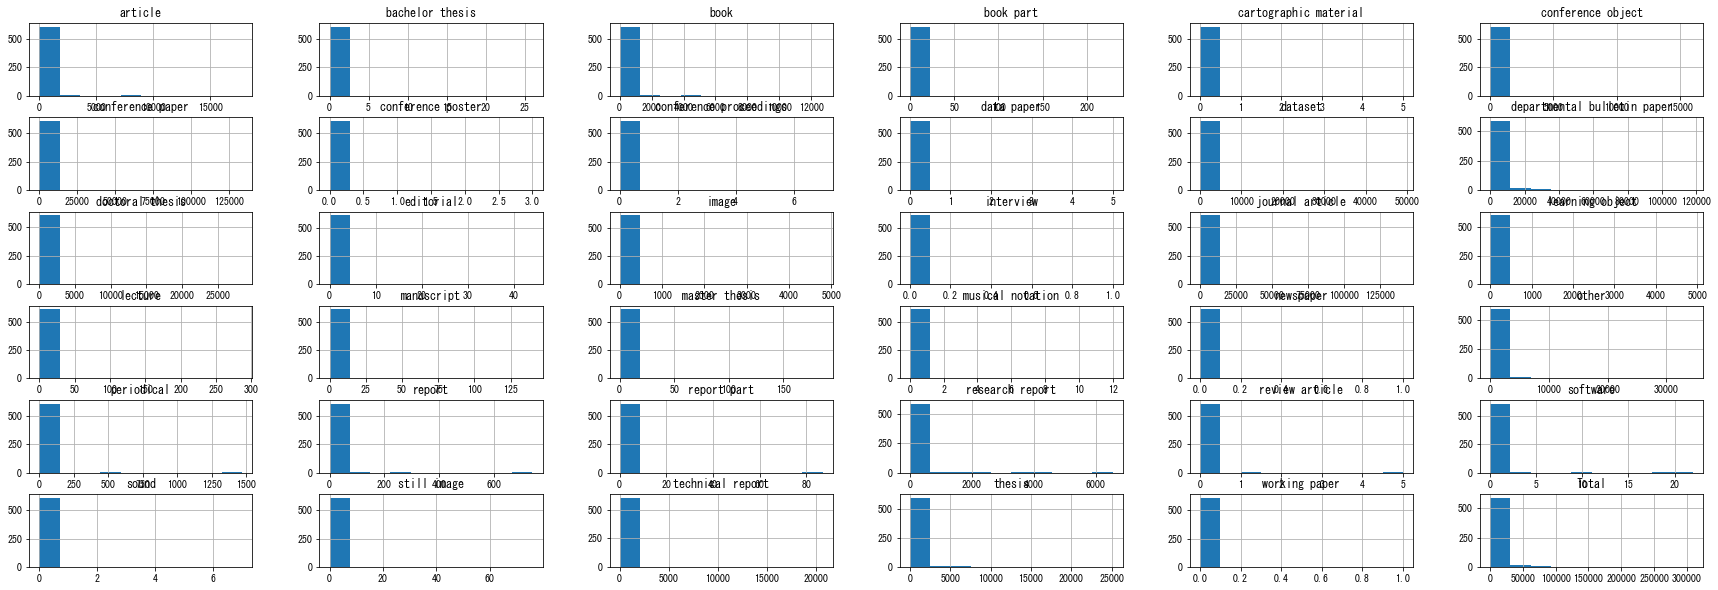

In [11]:
# 各列のヒストグラムを作成
# pivot_orders_df4 は実数値でソート済み、合計列が右端にある
plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(figsize=(30,10))
# pivot_orders_df4 は 元のDataFrame
pivot_orders_df4.hist(ax=ax)

#  ペアプロット図（散布図行列）
- とりあえず、紀要と雑誌論文の散布図を作成
- 全体の様子を見るため、ペアプロット図（散布図行列）を作成
- 全資源タイプ35×35だと、細かすぎるので、値の少ない資源タイプを削除（drop）

<AxesSubplot:xlabel='departmental bulletin paper', ylabel='journal article'>

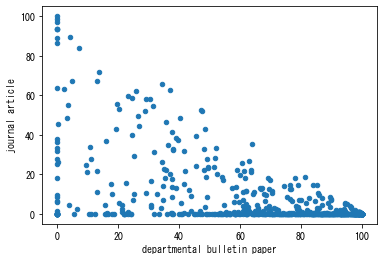

In [5]:
# 紀要と雑誌論文の散布図を作成
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams["font.family"] = "MS Gothic"
plt.rcParams['font.size'] = 10
# fig, ax = plt.subplots(figsize=(30,10))
# pivot_orders_df4 は 元のDataFrame
pivot_orders_df5.plot.scatter(x='departmental bulletin paper', y='journal article')

In [6]:
# 各列の合計行を追加
pivot_orders_df6 = pd.concat([pivot_orders_df5,pd.DataFrame(pivot_orders_df5.sum(axis=0),columns=['GTotal']).T])
# GTotalが10より小さいもののカラム名をリストで取得して、dropする
#pivot_orders_df6[pivot_orders_df6.loc[['GTotal'] ,:] > 1].dropna(how='all', axis=1).columns
pivot_orders_df7 = pivot_orders_df6.drop(pivot_orders_df6[pivot_orders_df6.loc[['GTotal'] ,:] < 10].dropna(how='all', axis=1).columns, axis=1)

In [35]:
# 紀要の列のみをソート
# print(pivot_orders_df7.sort_values("departmental bulletin paper", ascending=False)['departmental bulletin paper'])
# 紀要 100%の行を抽出
kiyou = (pivot_orders_df7['departmental bulletin paper'] == 100)
# 紀要 100%の個数
kiyou.sum()
# print(kiyou[kiyou])

秋田工業高等専門学校     True
大阪国際大学         True
八戸学院大学         True
東京女子体育大学       True
田園調布学園大学       True
沖縄大学           True
高松大学           True
岡山商科大学         True
豊橋創造大学         True
茨城キリスト教大学      True
鎌倉女子大学         True
新潟産業大学         True
愛知みずほ大学        True
松本短期大学         True
神戸医療福祉大学       True
湘北短期大学         True
大和大学           True
志學館大学          True
ものつくり大学        True
羽陽学園短期大学       True
デジタルハリウッド大学    True
群馬県立女子大学       True
姫路大学           True
福山平成大学         True
長野女子短期大学       True
畿央大学           True
新島学園短期大学       True
桜の聖母短期大学       True
福岡看護大学         True
京都精華大学         True
長野保健医療大学       True
女子美術大学         True
Name: departmental bulletin paper, dtype: bool


<class 'seaborn.axisgrid.PairGrid'>


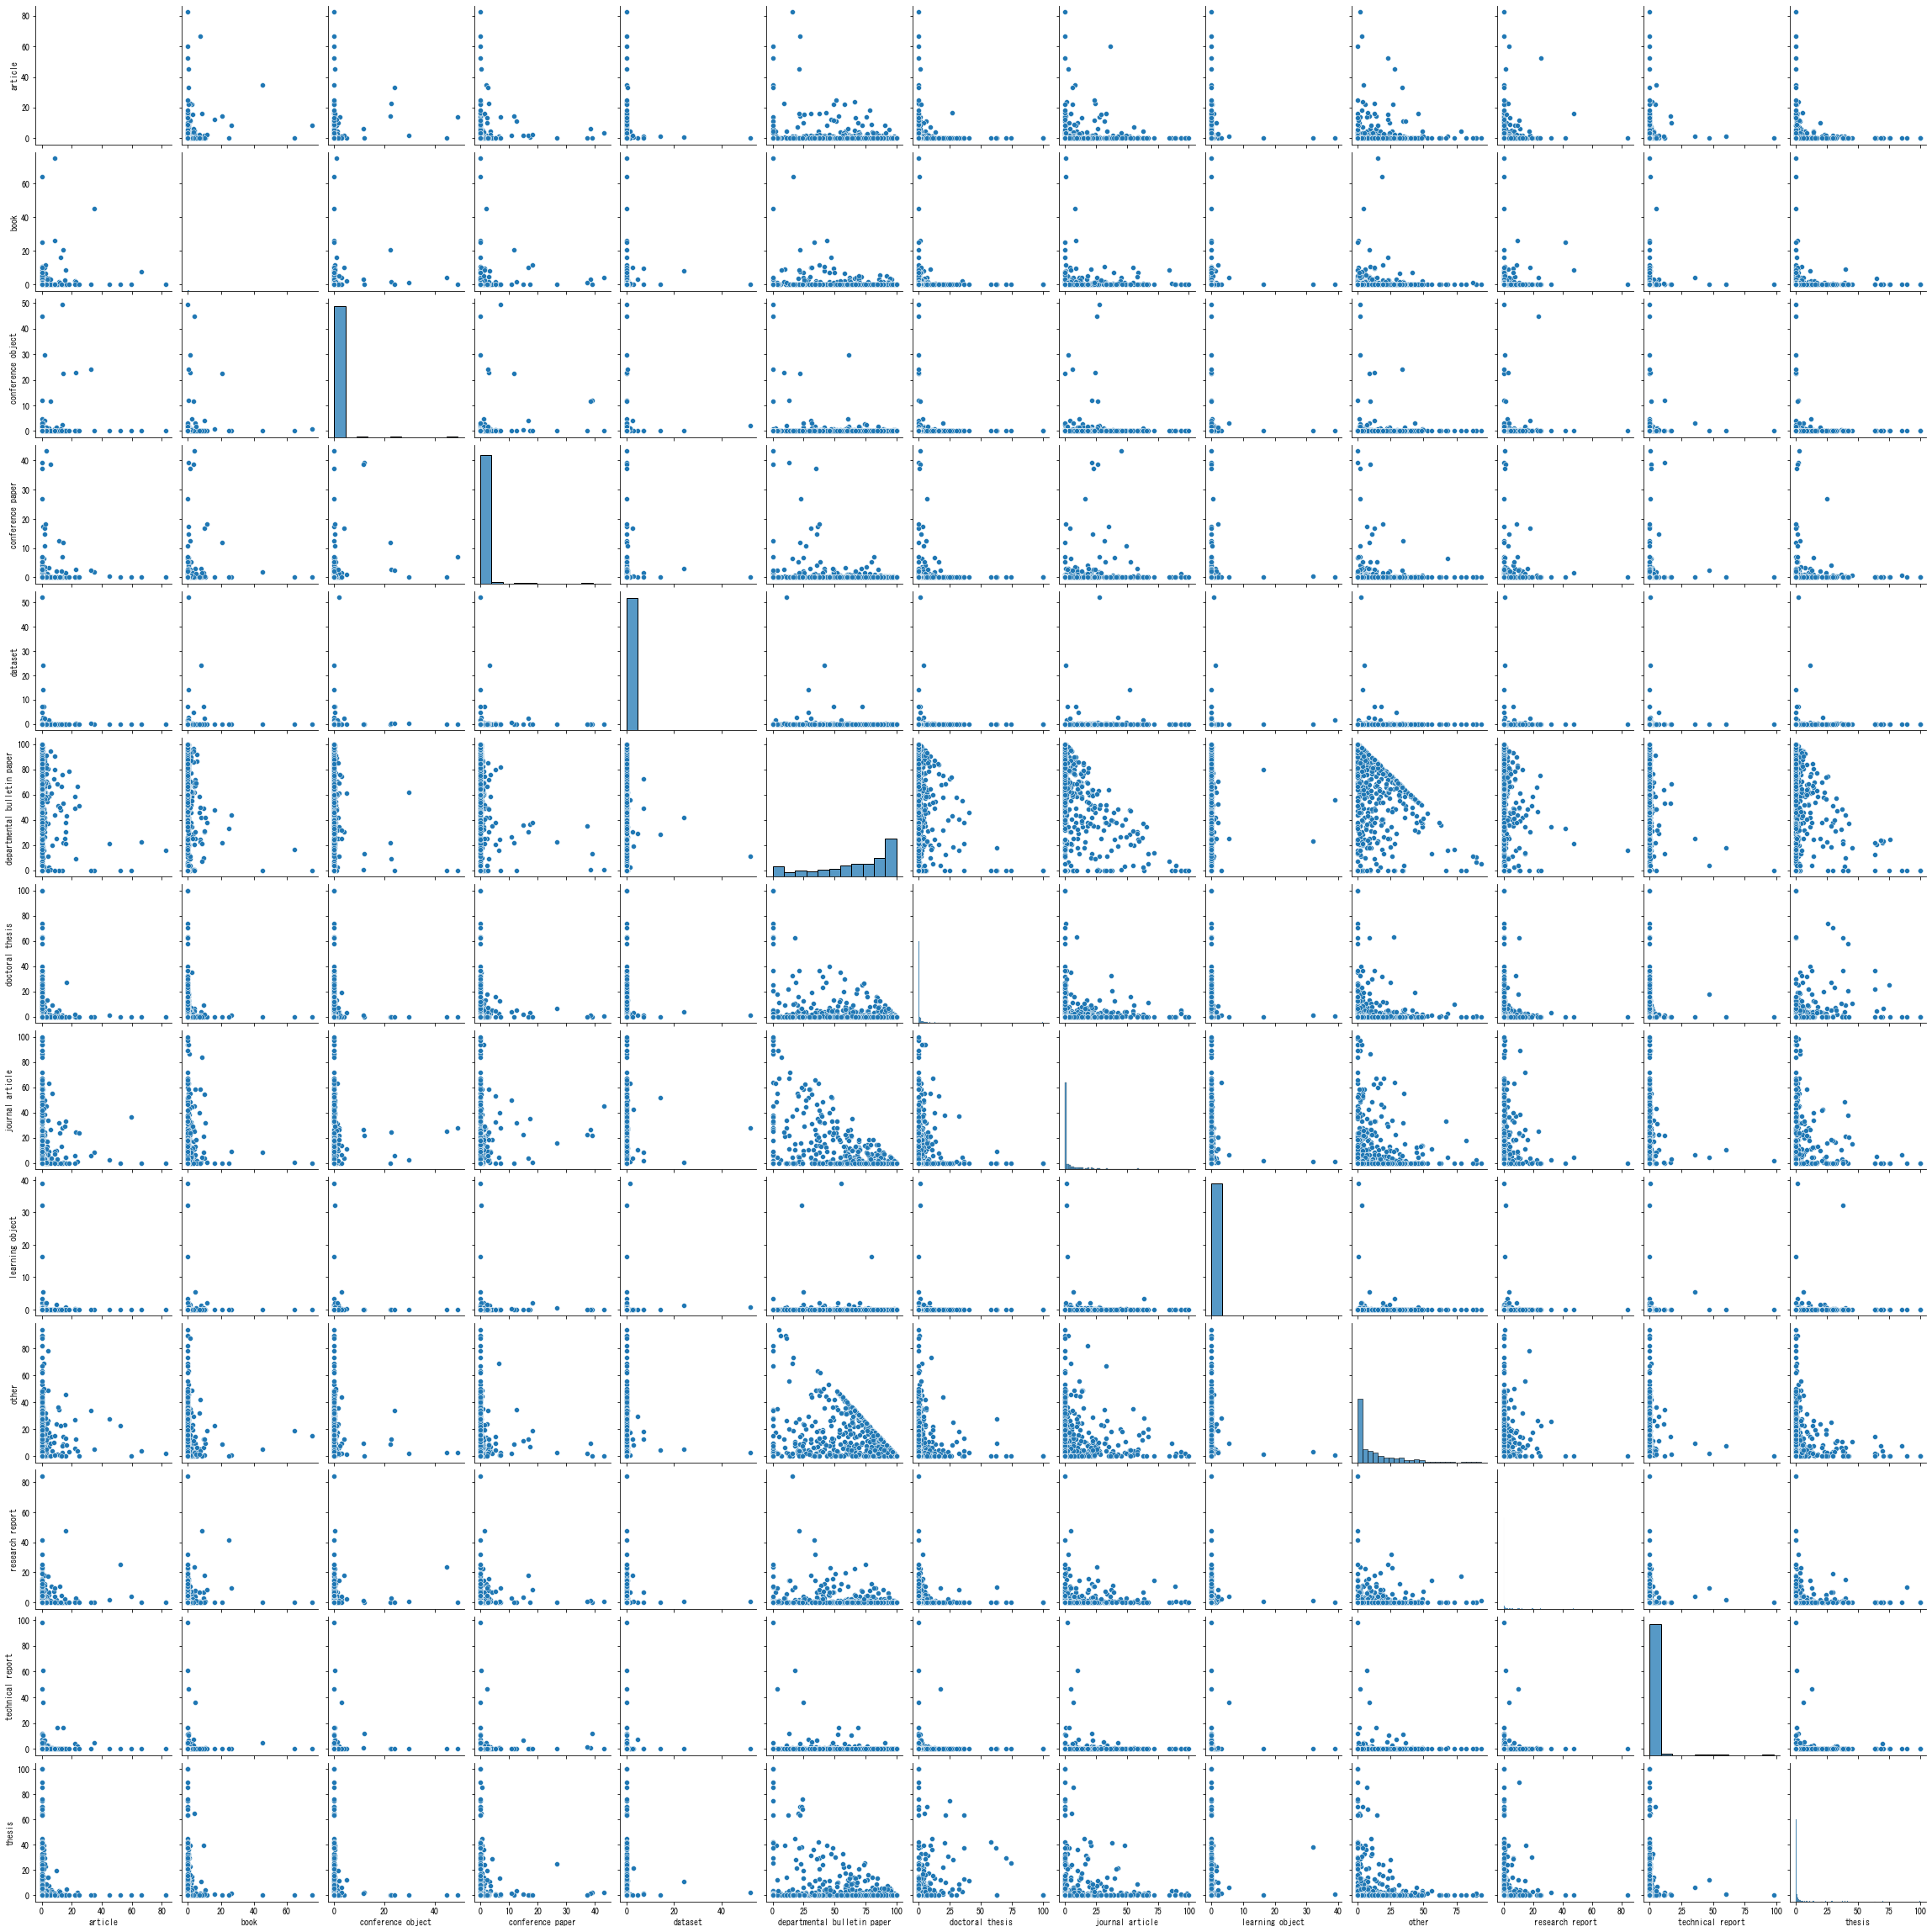

In [73]:
# ペアプロット図（散布図行列）
# 35×35で散布行列図を描くと細かすぎ、7分くらいかかる。
# import pandas as pd
import seaborn as sns
pg = sns.pairplot(pivot_orders_df7.iloc[0:612,0:13])
print(type(pg))
# 14ｘ14で6m9.1sかかった

In [44]:
# 科研費採択数のDFを読み込み
kakenhidf = pd.read_pickle('kakenhidf.pkl.gz', compression='gzip') # 圧縮有り

In [45]:
kakenhidf = kakenhidf.set_index('機関名')
kakenhidf.index.name="institutions"

In [46]:
kakenhidf

,採択件数（件）
institutions,
東京大学,4202
京都大学,3022
大阪大学,2665
東北大学,2525
九州大学,1943
...,...
科学教育総合研究所株式会社（研究・開発部）,1
株式会社辻料理教育研究所（辻静雄料理教育研究所 研究部門）,1
社会医療法人神鋼記念会（総合医学研究センター）,1


In [59]:
pivot_orders_df3

,article,bachelor thesis,book,book part,cartographic material,conference object,conference paper,conference poster,conference proceedings,data paper,...,report part,research report,review article,software,sound,still image,technical report,thesis,working paper,Total
institutions,,,,,,,,,,,,,,,,,,,,,
お茶の水女子大学,17818,0,55,0,0,61,133,0,0,0,...,0,619,0,0,0,0,0,0,0,39468
こども教育宝仙大学,0,0,3,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,162
つくば国際大学,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,569
びわこ成蹊スポーツ大学,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,125,2062,0,2944
ものつくり大学,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
鹿児島純心女子大学,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,445
鹿児島純心女子短期大学,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,103
鹿屋体育大学,0,0,0,0,0,0,0,0,0,0,...,0,230,0,0,0,0,0,33,0,1158


In [88]:
# ２つのDataFrameをindexをキーにマージ
# institutions	
# print(pd.merge(pivot_orders_df5, kakenhidf), on='institutions', how='inner')
# 百分率pivot_orders_df5 と科研費採択数をマージしても無意味だった
kakenhimerge = pd.merge(pivot_orders_df3, kakenhidf, left_index=True, right_index=True, how='inner')
kakenhimerge['採択件数（件）'] = pd.to_numeric(kakenhimerge['採択件数（件）'], errors='coerce') # .astype(str).str.replace(',', '')
kakenhisort = kakenhimerge.sort_values(by=['採択件数（件）','Total'], ascending=True)
# pivot_orders_df4 = pivot_orders_df3.sort_values(by='Total', ascending=False) 
kakenhisort

,article,bachelor thesis,book,book part,cartographic material,conference object,conference paper,conference poster,conference proceedings,data paper,...,research report,review article,software,sound,still image,technical report,thesis,working paper,Total,採択件数（件）
institutions,,,,,,,,,,,,,,,,,,,,,
女子美術大学,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,22,1
桜の聖母短期大学,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,47,1
新島学園短期大学,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,54,1
東京造形大学,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,64,1
滋賀文教短期大学,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,81,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
九州大学,2353,0,159,0,0,394,1761,0,0,0,...,966,0,0,0,0,852,3878,0,51308,1943
東北大学,0,0,2,0,0,50,0,0,0,0,...,0,0,0,0,0,0,4757,0,77257,2525
大阪大学,19,0,189,0,0,126,250,0,0,0,...,447,0,0,0,0,1484,25140,0,79412,2665


<AxesSubplot:xlabel='採択件数（件）', ylabel='Total'>

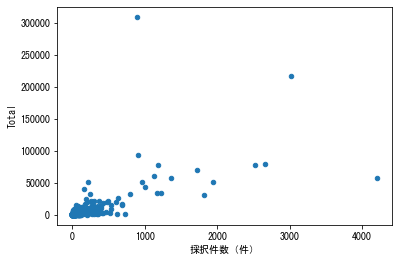

In [89]:
# 合計と科研費採択数の散布図を作成 Total	採択件数（件）
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams["font.family"] = "MS Gothic"
plt.rcParams['font.size'] = 10
# fig, ax = plt.subplots(figsize=(30,10))
# pivot_orders_df4 は 元のDataFrame
kakenhisort.plot.scatter(x='採択件数（件）', y='Total')